#### This notebook generates convergence plots for the backward Euler and the implicit midpoint method on the heat equation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
weights_lib = { 
                'Euler 1-step 1-order' : [1],
                'Euler 2-step 2-order' : [0.5 +0.5*1j, 0.5-0.5*1j],
                'Euler 2-step 3-order' : [1+1j*np.sqrt(2)/2,-1j*np.sqrt(2)/2],
                'Euler 2-step 3-order exp' : [0.838852+1j*0.604004, 0.161148-1j*0.604004],
                'Euler 2-step symplectic' : [0.5 +0.5*np.sqrt(3)*1j, 0.5-0.5*np.sqrt(3)*1j],
                'Euler 3-step 1-order' : [8.29344624e-01 , 5.95442650e-02, 1-8.29344624e-01-5.95442650e-02],
                'Euler 3-step 3-order' : [0.1867308533646 + 0.480773884550331*1j, 0.626538293270800, 0.1867308533646 - 0.480773884550331*1j],
                'Euler 3-step 2-order' : [0.411741936185254 + 0.430244574248458*1j, 0.176516127629493, 0.411741936185254-0.430244574248458*1j],
                'Euler 4-step 4-order' : [   0.04262665650273905+0.394632953172082*1j,
                                           0.4573733434973006-0.23510048799854047j, 0.4573733434973006+0.23510048799854047j, 0.04262665650273905-0.394632953172082*1j],
                'Euler 4-step 5-order' :[0.468161714486717 - 0.26941588085837*1j, 0.160647423722113 + 0.351192187389791*1j,0.335788810038662 + 0.241712151385474*1j, 
                                         0.0354020517525083 - 0.323488457916895*1j],
                'Midpo 2-step 4-order' :[0.5 + 0.28867513459*1j, 0.5-0.28867513459*1j]}

def pathwise(x, path):
    stepsize = x[1:]-x[:-1]
    contour = [x[0]]
    for i in range(len(x)-1):
        weights = np.cumsum(weights_lib[path])
        substeps = [x[i]+stepsize[i]*weight for weight in weights]
        contour +=substeps
    return np.array(contour)

In [6]:
L = 1 # length of domain
N = 7000#spatial steps
dx = L/(N-1)
x = np.linspace(0, L, N)

u_init = np.sin(np.pi*x) # gausssian initial condition

#creating central difference matrix
def tridiag(a, b, c, d, k1=0, k2=1, k3=2, k4 =3):
    return np.diag(a, k1) + np.diag(b, k2)+ np.diag(b, -k2)+np.diag(c, k3)+np.diag(c, -k3)#+np.diag(d, k4)+np.diag(d, -k4)

cfl = 1/dx**2

b = (4/3)*cfl*np.ones(N-1, dtype=np.complex_)
b[-1] = 0 #boundary set to 0
b[0] = 0 #boundary set to 0
a = -2.5*cfl*np.ones(N, dtype=np.complex_)
c = -(1/12)*cfl*np.ones(N-2, dtype=np.complex_)
d = (1/90)*cfl*np.ones(N-5, dtype=np.complex_)

c[-1] = 0 #boundary set to 0
c[0] = 0 #boundary set to 0

A = tridiag(a, b, c, d)
A[1][:7] = cfl*np.array([0, 15/4, -77/6, 107/6, -13, 61/12, -5/6])
A[-2][-7:] = cfl*np.array([-5/6, 61/12,-13, 107/6, -77/6, 15/4, 0])

I = np.eye(N, dtype=np.complex_)

end = 0.1
timestep = 0.001
t = np.linspace(0, end, int(end/timestep)+1)
scheme = 'Euler 3-step 3-order'
path1 = pathwise(t, scheme)
steps = path1[1:]-path1[:-1]


In [7]:
class IVP(object):
    def __init__(self, f=None, u0=1., t0=0., T=1., exact=None, desc='', name=''):
        self.u0  = u0
        self.rhs = f
        self.T   = T
        self.exact = exact
        self.description = desc
        self.t0 = t0
        self.name = name

In [8]:
u0 = u_init
rhs = lambda t,u: A
exact = lambda t, u0=u0: np.array([np.exp(-np.pi**2*timepoint)*np.sin(np.pi*x) for timepoint in t])
heat = IVP(f=rhs, u0=u0, T = 0.1, exact = exact)

In [9]:
def convergence_test_backward(timesteps, schemes, ode):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        t = np.linspace(0, end, int(end/timestep+1))
        exact = ode.exact(t, x)
        
        scheme_error = []
        for scheme in schemes:
            num_steps = int(scheme[6])
            path1 = pathwise(t, scheme)
            steps = path1[1:]-path1[:-1]
            A_list = []
            weights = weights_lib[scheme]
            for i in range(num_steps):
                weight = weights[i]
                inverse = np.linalg.inv(I - weight*timestep*A)
                A_list.append(inverse)
            
            y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.complex_)
            y1[0] = ode.u0

            i = 1
            for step in steps:
                y1[i][1:-1] = np.dot(A_list[i%num_steps-1], y1[i-1])[1:-1]
                if i%num_steps ==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::num_steps]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)

In [10]:
timesteps = np.array([0.01,0.005, 0.001])
schemes = [ 'Euler 3-step 3-order']#'Euler 2-step 3-order exp','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']

#schemes = ['Euler 2-step 3-order']
er = convergence_test_backward(timesteps, schemes, heat)
er

array([[6.06818400e-02],
       [7.89041211e-03],
       [6.54564886e-05]])

# Midpoint Method

In [12]:
def convergence_test_midpoint(timesteps, schemes, ode):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        t = np.linspace(0, end, int(end/timestep+1))
        exact = ode.exact(t, x)
        
        scheme_error = []
        for scheme in schemes:
            num_steps = int(scheme[6])
            path1 = pathwise(t, scheme)
            steps = path1[1:]-path1[:-1]
            A_list = []
            weights = weights_lib[scheme]
            for i in range(num_steps):
                weight = weights[i]
                denom_inv = np.linalg.inv(I - 0.5*weight*timestep*A)
                numerator = I + 0.5*weight*timestep*A
                A_list.append(np.dot(denom_inv,numerator))
            
            y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.complex_)
            y1[0] = ode.u0

            i = 1
            for step in steps:
                y1[i][1:-1] = np.dot(A_list[i%num_steps-1], y1[i-1])[1:-1]
                if i%num_steps ==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::num_steps]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)

In [13]:
timesteps1 = np.array([0.05, 0.01,  0.005])
schemes = ['Euler 1-step 1-order', 'Midpo 2-step 4-order'] #'Euler 2-step 2-order', 'Euler 3-step 3-order']#'Euler 2-step 3-order exp','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']

#schemes = ['Euler 2-step 3-order']
er1 = convergence_test_midpoint(timesteps1, schemes, heat)
er1

array([[3.41754671e+01, 1.36963342e-01],
       [1.33187548e+00, 2.15365618e-04],
       [3.32704694e-01, 1.29784461e-05]])

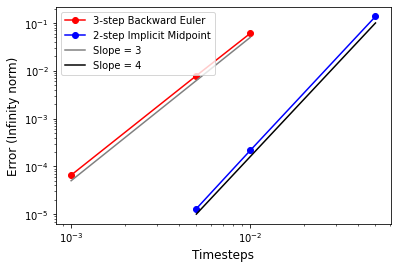

In [14]:
plt.figure()
plt.loglog(timesteps, er[:, 0], 'r-o', label = '3-step Backward Euler')
plt.loglog(timesteps1, er1[:, 1], 'b-o', label = '2-step Implicit Midpoint')
plt.loglog([0.01, 0.001], [0.05, 5e-05], 'gray',  label = 'Slope = 3')
plt.loglog([0.05, 0.005], [0.1, 1e-05], 'k',  label = 'Slope = 4')
plt.xlabel('Timesteps', fontsize =12)
plt.ylabel('Error (Infinity norm)', fontsize =12)
plt.legend()
plt.savefig('implicit_heat.pdf')